# Project 3 Presentation - Gradient Boosting Regresion Trees

<br> We present our scores on the **Liberty Mutual Group Property Inspection Prediction** Dataset. 

A Fortune 100 company, Liberty Mutual Insurance has provided a wide range of insurance products and services designed to meet their customers' ever-changing needs for over 100 years.

To ensure that Liberty Mutual’s portfolio of home insurance policies aligns with their business goals, many newly insured properties receive a home inspection. These inspections review the condition of key attributes of the property, including things like the foundation, roof, windows and siding. The results of an inspection help Liberty Mutual determine if the property is one they want to insure.

In this challenge, your task is to predict a transformed count of hazards or pre-existing damages using a dataset of property information. This will enable Liberty Mutual to more accurately identify high risk homes that require additional examination to confirm their insurability.

In [1]:
# Constants - Change the next cell according to your local paths!
GBRT_DIR_PATH = '/home/pereldamian/PycharmProjects/gbrt_new'
TRAIN_DATA_PATH = './data_liberty/train.csv'
LABEL_NAME = 'Hazard'

In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import sys
import pandas as pd
import numpy as np
import operator
import warnings
import pickle
warnings.filterwarnings('ignore')

# GBRT imports of our implementation
sys.path.insert(0, GBRT_DIR_PATH)
from data_utils import parse_data
from gbrt_algorithm import gbrt
from feature_selection import ensemble_feature_importance

np.random.seed(0)

In [3]:
class HParams:
    def __init__(self, num_trees=50, max_depth=3, min_node_size=0, weight_decay=1.0, sub_samp=1.0, num_thresholds=10,
                 verbose=1):
        self.num_trees = num_trees
        self.max_depth = max_depth
        self.min_node_size = min_node_size
        self.weight_decay = weight_decay
        self.sub_samp = sub_samp
        self.num_thresholds = num_thresholds
        self.verbose = verbose

# Load Data

In [4]:
train_dataset, test_dataset = parse_data(TRAIN_DATA_PATH, label_name=LABEL_NAME)

# Data Exploration

In [5]:
train_dataset.data.head(5)

,Hazard,T1_V1,T1_V2,T1_V3,T1_V4,T1_V5,T1_V6,T1_V7,T1_V8,T1_V9,...,T2_V6,T2_V7,T2_V8,T2_V9,T2_V10,T2_V11,T2_V12,T2_V13,T2_V14,T2_V15
Id,,,,,,,,,,,,,,,,,,,,,
1,1,15,3,2,7.0,6.0,2.0,3.0,2.0,3.0,...,2,37,1,11,6,2.0,2.0,2.0,2,2
2,4,16,14,5,8.0,6.0,2.0,3.0,2.0,1.0,...,2,22,1,18,5,2.0,1.0,2.0,2,1
3,1,10,10,5,7.0,8.0,2.0,3.0,2.0,6.0,...,6,37,2,14,6,2.0,1.0,2.0,6,1
4,1,18,18,5,7.0,8.0,2.0,3.0,2.0,6.0,...,2,25,1,1,6,2.0,2.0,3.0,2,6
5,1,13,19,5,7.0,4.0,2.0,3.0,2.0,6.0,...,1,22,1,2,7,1.0,2.0,2.0,1,1


In [6]:
train_dataset.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40799 entries, 1 to 101999
Data columns (total 33 columns):
Hazard    40799 non-null int64
T1_V1     40799 non-null int64
T1_V2     40799 non-null int64
T1_V3     40799 non-null int64
T1_V4     40799 non-null float64
T1_V5     40799 non-null float64
T1_V6     40799 non-null float64
T1_V7     40799 non-null float64
T1_V8     40799 non-null float64
T1_V9     40799 non-null float64
T1_V10    40799 non-null int64
T1_V11    40799 non-null float64
T1_V12    40799 non-null float64
T1_V13    40799 non-null int64
T1_V14    40799 non-null int64
T1_V15    40799 non-null float64
T1_V16    40799 non-null float64
T1_V17    40799 non-null float64
T2_V1     40799 non-null int64
T2_V2     40799 non-null int64
T2_V3     40799 non-null float64
T2_V4     40799 non-null int64
T2_V5     40799 non-null float64
T2_V6     40799 non-null int64
T2_V7     40799 non-null int64
T2_V8     40799 non-null int64
T2_V9     40799 non-null int64
T2_V10    40799 non-null in

# Model Selection

We train few models, each with different hyper parameters in order to minimize the loss on the test set. Ideally we would have done a grid search over the parameter space, but because of time constraints, we search only on the following values.
<br>All models logs are saved in models_data dictionary.

In [7]:
models_data = {}

In [8]:
params_list = []

weight_decay_list = [0.6, 0.9, 0.1, 0.3]
for weight_decay in weight_decay_list:
    params = HParams(num_trees=150, max_depth=3, min_node_size=0, 
                     weight_decay=weight_decay, sub_samp=0.7, verbose=1, num_thresholds=10)
    params_list.append(params)
    
max_depth_list = [5, 2, 7, 1]
for max_depth in max_depth_list:
    params = HParams(num_trees=150, max_depth=max_depth, min_node_size=0, 
                     weight_decay=0.6, sub_samp=0.7, verbose=1, num_thresholds=10)
    params_list.append(params)
    

num_thresh_list = [2, 20, 5, 15]
for num_thresh in num_thresh_list:
    params = HParams(num_trees=150, max_depth=3, min_node_size=0, 
                     weight_decay=0.6, sub_samp=0.7, verbose=1, num_thresholds=num_thresh)
    params_list.append(params)

    
for p in params_list:
    print('Start {} {} {}'.format(p.max_depth, p.weight_decay, p.num_thresholds))

    model, model_log = gbrt(train_data=train_dataset.data, test_data=test_dataset.data, 
                   label_name=train_dataset.label_name, params=p)

    models_data[(p.max_depth, p.weight_decay, p.num_thresholds)] = model_log
    
    
with open('model_dataaa.pickle', 'wb') as handle:
    pickle.dump(models_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Start 3 0.6 10
Add tree number 1
Train mean loss is: 17.98017419438772
Test mean loss is: 18.174112975326512
Add tree number 2
Train mean loss is: 15.50752922103379
Test mean loss is: 15.634681087496157
Add tree number 3
Train mean loss is: 14.986424275262678
Test mean loss is: 15.161014096909573
Add tree number 4
Train mean loss is: 14.76523192879695
Test mean loss is: 14.947130051760725
Add tree number 5
Train mean loss is: 14.665714740278913
Test mean loss is: 14.850188663738507
Add tree number 6
Train mean loss is: 14.56557390464378
Test mean loss is: 14.79660912732819
Add tree number 7
Train mean loss is: 14.465940808615283
Test mean loss is: 14.693757030325106
Add tree number 8
Train mean loss is: 14.409308203352557
Test mean loss is: 14.667019222396148
Add tree number 9
Train mean loss is: 14.37002657442843
Test mean loss is: 14.64761013617966
Add tree number 10
Train mean loss is: 14.33166196999271
Test mean loss is: 14.63551148496954
Add tree number 11
Train mean loss is: 14.2

Add tree number 87
Train mean loss is: 13.43489293732138
Test mean loss is: 14.658860222759257
Add tree number 88
Train mean loss is: 13.429408007109732
Test mean loss is: 14.65598969845586
Add tree number 89
Train mean loss is: 13.424140189076455
Test mean loss is: 14.65501414822462
Add tree number 90
Train mean loss is: 13.417944287554768
Test mean loss is: 14.656966079002071
Add tree number 91
Train mean loss is: 13.414392488278644
Test mean loss is: 14.656197936367146
Add tree number 92
Train mean loss is: 13.411264482230267
Test mean loss is: 14.649295789883741
Add tree number 93
Train mean loss is: 13.404946696401513
Test mean loss is: 14.651733116338143
Add tree number 94
Train mean loss is: 13.399537090528288
Test mean loss is: 14.653667412752533
Add tree number 95
Train mean loss is: 13.394121521416006
Test mean loss is: 14.648244951688588
Add tree number 96
Train mean loss is: 13.386600982693471
Test mean loss is: 14.643597928153353
Add tree number 97
Train mean loss is: 13.3

Add tree number 23
Train mean loss is: 13.974445483835156
Test mean loss is: 14.65901470781263
Add tree number 24
Train mean loss is: 13.950657494340218
Test mean loss is: 14.674091944373698
Add tree number 25
Train mean loss is: 13.933104105122602
Test mean loss is: 14.636818942460565
Add tree number 26
Train mean loss is: 13.913484465680094
Test mean loss is: 14.62931324437185
Add tree number 27
Train mean loss is: 13.900430396214102
Test mean loss is: 14.619181751867682
Add tree number 28
Train mean loss is: 13.879874234545639
Test mean loss is: 14.609046235109298
Add tree number 29
Train mean loss is: 13.867650529413906
Test mean loss is: 14.625820879752812
Add tree number 30
Train mean loss is: 13.860952509969191
Test mean loss is: 14.622154164287277
Add tree number 31
Train mean loss is: 13.848917998022664
Test mean loss is: 14.631826824571116
Add tree number 32
Train mean loss is: 13.832244711800307
Test mean loss is: 14.63002382677514
Add tree number 33
Train mean loss is: 13.8

Add tree number 109
Train mean loss is: 13.16500927516298
Test mean loss is: 14.752512849489635
Add tree number 110
Train mean loss is: 13.153444374174098
Test mean loss is: 14.761321090430814
Add tree number 111
Train mean loss is: 13.145147391186313
Test mean loss is: 14.768708047046399
Add tree number 112
Train mean loss is: 13.139978557956653
Test mean loss is: 14.76460101958526
Add tree number 113
Train mean loss is: 13.134835009504899
Test mean loss is: 14.776026529458816
Add tree number 114
Train mean loss is: 13.12669446977293
Test mean loss is: 14.778716952276774
Add tree number 115
Train mean loss is: 13.122992923128942
Test mean loss is: 14.78027606786582
Add tree number 116
Train mean loss is: 13.118613592485291
Test mean loss is: 14.778396613724594
Add tree number 117
Train mean loss is: 13.112074500356771
Test mean loss is: 14.77605505275927
Add tree number 118
Train mean loss is: 13.104626792130812
Test mean loss is: 14.78355423142021
Add tree number 119
Train mean loss 

Add tree number 45
Train mean loss is: 14.384108817369443
Test mean loss is: 14.697442342404393
Add tree number 46
Train mean loss is: 14.37154516923621
Test mean loss is: 14.68815647045765
Add tree number 47
Train mean loss is: 14.359389603012561
Test mean loss is: 14.673957135077286
Add tree number 48
Train mean loss is: 14.34731340167834
Test mean loss is: 14.666347915648936
Add tree number 49
Train mean loss is: 14.337086646806306
Test mean loss is: 14.658203713640795
Add tree number 50
Train mean loss is: 14.325900165501203
Test mean loss is: 14.652481296991327
Add tree number 51
Train mean loss is: 14.317924284286661
Test mean loss is: 14.644643070109764
Add tree number 52
Train mean loss is: 14.311367610357987
Test mean loss is: 14.63927467150297
Add tree number 53
Train mean loss is: 14.29734303353428
Test mean loss is: 14.631649924816644
Add tree number 54
Train mean loss is: 14.286021903085828
Test mean loss is: 14.622750894162388
Add tree number 55
Train mean loss is: 14.277

Add tree number 131
Train mean loss is: 13.914677384446033
Test mean loss is: 14.41331540896469
Add tree number 132
Train mean loss is: 13.911414292863714
Test mean loss is: 14.412716153431234
Add tree number 133
Train mean loss is: 13.909396575130863
Test mean loss is: 14.412448658222429
Add tree number 134
Train mean loss is: 13.906906521941826
Test mean loss is: 14.410616400920802
Add tree number 135
Train mean loss is: 13.904631785569686
Test mean loss is: 14.411428218512619
Add tree number 136
Train mean loss is: 13.899650352555476
Test mean loss is: 14.40976522049663
Add tree number 137
Train mean loss is: 13.897609361252872
Test mean loss is: 14.409087477355573
Add tree number 138
Train mean loss is: 13.895415722777322
Test mean loss is: 14.410158313190061
Add tree number 139
Train mean loss is: 13.893936711485676
Test mean loss is: 14.409781715080115
Add tree number 140
Train mean loss is: 13.89163165994186
Test mean loss is: 14.409233345451238
Add tree number 141
Train mean lo

Add tree number 67
Train mean loss is: 13.821095552675
Test mean loss is: 14.4340230648182
Add tree number 68
Train mean loss is: 13.813329796850455
Test mean loss is: 14.43814387250911
Add tree number 69
Train mean loss is: 13.807800218793906
Test mean loss is: 14.43955940656488
Add tree number 70
Train mean loss is: 13.797984559824677
Test mean loss is: 14.438237987808352
Add tree number 71
Train mean loss is: 13.794662208221954
Test mean loss is: 14.437412253194488
Add tree number 72
Train mean loss is: 13.79055257278782
Test mean loss is: 14.434434311567383
Add tree number 73
Train mean loss is: 13.786571911403577
Test mean loss is: 14.429952567203216
Add tree number 74
Train mean loss is: 13.779787646500475
Test mean loss is: 14.428264357340808
Add tree number 75
Train mean loss is: 13.770411407331306
Test mean loss is: 14.424042231092105
Add tree number 76
Train mean loss is: 13.76516089416204
Test mean loss is: 14.425907443784126
Add tree number 77
Train mean loss is: 13.7624953

Add tree number 3
Train mean loss is: 14.404913576543947
Test mean loss is: 15.028306456290057
Add tree number 4
Train mean loss is: 14.150555648387966
Test mean loss is: 14.941939703339283
Add tree number 5
Train mean loss is: 13.961783774114442
Test mean loss is: 15.00297479299066
Add tree number 6
Train mean loss is: 13.862815028337439
Test mean loss is: 14.97260639702336
Add tree number 7
Train mean loss is: 13.779881219678938
Test mean loss is: 14.96162565280605
Add tree number 8
Train mean loss is: 13.686039240316367
Test mean loss is: 14.969952381539787
Add tree number 9
Train mean loss is: 13.604191486169103
Test mean loss is: 14.966678885409218
Add tree number 10
Train mean loss is: 13.521647198369408
Test mean loss is: 14.965838103287814
Add tree number 11
Train mean loss is: 13.463131184613848
Test mean loss is: 14.959828594012883
Add tree number 12
Train mean loss is: 13.397549432254198
Test mean loss is: 14.932814030655065
Add tree number 13
Train mean loss is: 13.33269196

Add tree number 89
Train mean loss is: 10.96154655637157
Test mean loss is: 15.759203032830701
Add tree number 90
Train mean loss is: 10.944516934292142
Test mean loss is: 15.732571607461528
Add tree number 91
Train mean loss is: 10.927866430882359
Test mean loss is: 15.745483546120152
Add tree number 92
Train mean loss is: 10.907892822674876
Test mean loss is: 15.751628760869245
Add tree number 93
Train mean loss is: 10.88825823296834
Test mean loss is: 15.765544498105266
Add tree number 94
Train mean loss is: 10.872569944925582
Test mean loss is: 15.779472531956525
Add tree number 95
Train mean loss is: 10.84436807513756
Test mean loss is: 15.803043797361957
Add tree number 96
Train mean loss is: 10.82776533198453
Test mean loss is: 15.80491913965189
Add tree number 97
Train mean loss is: 10.801691536454534
Test mean loss is: 15.808966606204372
Add tree number 98
Train mean loss is: 10.775859953351855
Test mean loss is: 15.810857799366731
Add tree number 99
Train mean loss is: 10.755

Add tree number 25
Train mean loss is: 14.372992378309759
Test mean loss is: 14.646171547825036
Add tree number 26
Train mean loss is: 14.369416303551287
Test mean loss is: 14.640590747924696
Add tree number 27
Train mean loss is: 14.366084064717473
Test mean loss is: 14.636134001374847
Add tree number 28
Train mean loss is: 14.362266981988999
Test mean loss is: 14.639911374947145
Add tree number 29
Train mean loss is: 14.356432949777092
Test mean loss is: 14.641574095814002
Add tree number 30
Train mean loss is: 14.349325316089939
Test mean loss is: 14.638614351512182
Add tree number 31
Train mean loss is: 14.344392825292108
Test mean loss is: 14.641244586853453
Add tree number 32
Train mean loss is: 14.331164736502881
Test mean loss is: 14.630366424013319
Add tree number 33
Train mean loss is: 14.3276792260719
Test mean loss is: 14.628133582305821
Add tree number 34
Train mean loss is: 14.320576667442436
Test mean loss is: 14.608872381419602
Add tree number 35
Train mean loss is: 14.

Add tree number 111
Train mean loss is: 14.000141427617322
Test mean loss is: 14.496477818938855
Add tree number 112
Train mean loss is: 13.995423034008486
Test mean loss is: 14.494983277341445
Add tree number 113
Train mean loss is: 13.993859422518556
Test mean loss is: 14.495367731878439
Add tree number 114
Train mean loss is: 13.98577847296315
Test mean loss is: 14.498730387617286
Add tree number 115
Train mean loss is: 13.984697266250455
Test mean loss is: 14.49813403640174
Add tree number 116
Train mean loss is: 13.982023607382581
Test mean loss is: 14.498998105302368
Add tree number 117
Train mean loss is: 13.980355227210707
Test mean loss is: 14.49933167174338
Add tree number 118
Train mean loss is: 13.973922718329653
Test mean loss is: 14.50598200933184
Add tree number 119
Train mean loss is: 13.971036480314561
Test mean loss is: 14.50362569533226
Add tree number 120
Train mean loss is: 13.96788005497913
Test mean loss is: 14.500902428403071
Add tree number 121
Train mean loss 

Add tree number 47
Train mean loss is: 8.649481278660794
Test mean loss is: 16.847587265548547
Add tree number 48
Train mean loss is: 8.5628541938342
Test mean loss is: 16.851057431456816
Add tree number 49
Train mean loss is: 8.489741229596323
Test mean loss is: 16.86364222902712
Add tree number 50
Train mean loss is: 8.415856997818103
Test mean loss is: 16.900177791375025
Add tree number 51
Train mean loss is: 8.335303671529388
Test mean loss is: 16.9412174286461
Add tree number 52
Train mean loss is: 8.280261834972741
Test mean loss is: 16.970640613779132
Add tree number 53
Train mean loss is: 8.208103369998552
Test mean loss is: 16.976957822896928
Add tree number 54
Train mean loss is: 8.1359556944659
Test mean loss is: 16.953440747637934
Add tree number 55
Train mean loss is: 8.066137390734786
Test mean loss is: 17.009583557669384
Add tree number 56
Train mean loss is: 8.01484787905062
Test mean loss is: 17.027880309607124
Add tree number 57
Train mean loss is: 7.950908935247574
T

Add tree number 134
Train mean loss is: 4.594325548412984
Test mean loss is: 18.735164410657664
Add tree number 135
Train mean loss is: 4.565887942554326
Test mean loss is: 18.748364242421516
Add tree number 136
Train mean loss is: 4.534576788311843
Test mean loss is: 18.776995437120625
Add tree number 137
Train mean loss is: 4.504190839843142
Test mean loss is: 18.792604069350592
Add tree number 138
Train mean loss is: 4.475554033021913
Test mean loss is: 18.805873273413088
Add tree number 139
Train mean loss is: 4.45263759527414
Test mean loss is: 18.811980384878236
Add tree number 140
Train mean loss is: 4.428712135015334
Test mean loss is: 18.821888810214617
Add tree number 141
Train mean loss is: 4.397558765218634
Test mean loss is: 18.83360655046348
Add tree number 142
Train mean loss is: 4.3682228490006585
Test mean loss is: 18.859377564092522
Add tree number 143
Train mean loss is: 4.336865013776748
Test mean loss is: 18.875790781282916
Add tree number 144
Train mean loss is: 4

Add tree number 70
Train mean loss is: 14.63231937866026
Test mean loss is: 14.773073516816492
Add tree number 71
Train mean loss is: 14.630960424280017
Test mean loss is: 14.773234281568394
Add tree number 72
Train mean loss is: 14.629722276316787
Test mean loss is: 14.770959371272575
Add tree number 73
Train mean loss is: 14.628085943328731
Test mean loss is: 14.769410868497415
Add tree number 74
Train mean loss is: 14.626928660991803
Test mean loss is: 14.770139644521617
Add tree number 75
Train mean loss is: 14.625911833097819
Test mean loss is: 14.769717224517137
Add tree number 76
Train mean loss is: 14.625058686795573
Test mean loss is: 14.769480008218176
Add tree number 77
Train mean loss is: 14.624549145800206
Test mean loss is: 14.769851080827845
Add tree number 78
Train mean loss is: 14.623885260107265
Test mean loss is: 14.768909802746943
Add tree number 79
Train mean loss is: 14.623109882369207
Test mean loss is: 14.7709104693727
Add tree number 80
Train mean loss is: 14.6

Add tree number 5
Train mean loss is: 14.880674952265426
Test mean loss is: 15.104763339483288
Add tree number 6
Train mean loss is: 14.797071613156623
Test mean loss is: 15.014015599812241
Add tree number 7
Train mean loss is: 14.720603311905432
Test mean loss is: 14.954983491125883
Add tree number 8
Train mean loss is: 14.670494316977141
Test mean loss is: 14.913878696970798
Add tree number 9
Train mean loss is: 14.627563817570362
Test mean loss is: 14.878222784708829
Add tree number 10
Train mean loss is: 14.600345400364866
Test mean loss is: 14.86028704439955
Add tree number 11
Train mean loss is: 14.564565373011055
Test mean loss is: 14.843283595985769
Add tree number 12
Train mean loss is: 14.543914500395275
Test mean loss is: 14.832195153270561
Add tree number 13
Train mean loss is: 14.520155919863642
Test mean loss is: 14.834598696987742
Add tree number 14
Train mean loss is: 14.498304492832812
Test mean loss is: 14.820314642681412
Add tree number 15
Train mean loss is: 14.4788

Add tree number 91
Train mean loss is: 13.784328294410406
Test mean loss is: 14.626466229912738
Add tree number 92
Train mean loss is: 13.781380464223641
Test mean loss is: 14.627568684975486
Add tree number 93
Train mean loss is: 13.778372551155528
Test mean loss is: 14.627400453840588
Add tree number 94
Train mean loss is: 13.774195746612733
Test mean loss is: 14.624413300791094
Add tree number 95
Train mean loss is: 13.77236996844612
Test mean loss is: 14.628994614407048
Add tree number 96
Train mean loss is: 13.768981656111238
Test mean loss is: 14.625605051651238
Add tree number 97
Train mean loss is: 13.766090749470258
Test mean loss is: 14.62779955329841
Add tree number 98
Train mean loss is: 13.761715626936391
Test mean loss is: 14.628853543077843
Add tree number 99
Train mean loss is: 13.75964072213639
Test mean loss is: 14.628782838845027
Add tree number 100
Train mean loss is: 13.757249153364906
Test mean loss is: 14.628414490213563
Add tree number 101
Train mean loss is: 13

Add tree number 27
Train mean loss is: 13.910488883178814
Test mean loss is: 14.50469358889315
Add tree number 28
Train mean loss is: 13.88652609397417
Test mean loss is: 14.511097555277868
Add tree number 29
Train mean loss is: 13.872040200447277
Test mean loss is: 14.501431155891948
Add tree number 30
Train mean loss is: 13.832972009585916
Test mean loss is: 14.481254104540348
Add tree number 31
Train mean loss is: 13.82458635797817
Test mean loss is: 14.480219118620335
Add tree number 32
Train mean loss is: 13.81803531183098
Test mean loss is: 14.480188800465958
Add tree number 33
Train mean loss is: 13.808650382953502
Test mean loss is: 14.490251154247394
Add tree number 34
Train mean loss is: 13.798862553751798
Test mean loss is: 14.491461286449148
Add tree number 35
Train mean loss is: 13.780151751672483
Test mean loss is: 14.489363551499224
Add tree number 36
Train mean loss is: 13.768849484357407
Test mean loss is: 14.492241876222009
Add tree number 37
Train mean loss is: 13.75

Add tree number 113
Train mean loss is: 13.096090237821478
Test mean loss is: 14.571372682811962
Add tree number 114
Train mean loss is: 13.090801493516258
Test mean loss is: 14.573964924429362
Add tree number 115
Train mean loss is: 13.087094468608305
Test mean loss is: 14.577288433913605
Add tree number 116
Train mean loss is: 13.079275604226739
Test mean loss is: 14.577638647948579
Add tree number 117
Train mean loss is: 13.069560383307975
Test mean loss is: 14.566895299444889
Add tree number 118
Train mean loss is: 13.06147176483512
Test mean loss is: 14.578093454281088
Add tree number 119
Train mean loss is: 13.055732007813774
Test mean loss is: 14.573654511887934
Add tree number 120
Train mean loss is: 13.055184153386413
Test mean loss is: 14.574145894297738
Add tree number 121
Train mean loss is: 13.045251465051026
Test mean loss is: 14.574677845286528
Add tree number 122
Train mean loss is: 13.039933736878783
Test mean loss is: 14.573982818839575
Add tree number 123
Train mean 

Add tree number 49
Train mean loss is: 13.808837232668996
Test mean loss is: 14.528976738583266
Add tree number 50
Train mean loss is: 13.80021218603619
Test mean loss is: 14.521429662179338
Add tree number 51
Train mean loss is: 13.789955128943454
Test mean loss is: 14.519027390340788
Add tree number 52
Train mean loss is: 13.783092996369707
Test mean loss is: 14.522328991286903
Add tree number 53
Train mean loss is: 13.770344969984576
Test mean loss is: 14.533488152931948
Add tree number 54
Train mean loss is: 13.764219562092682
Test mean loss is: 14.537837714641286
Add tree number 55
Train mean loss is: 13.75727990623167
Test mean loss is: 14.53672435883015
Add tree number 56
Train mean loss is: 13.749090942073046
Test mean loss is: 14.527069782089384
Add tree number 57
Train mean loss is: 13.741054139903298
Test mean loss is: 14.530950690380426
Add tree number 58
Train mean loss is: 13.736998531270139
Test mean loss is: 14.533288544604387
Add tree number 59
Train mean loss is: 13.7

Add tree number 135
Train mean loss is: 13.313983057046931
Test mean loss is: 14.624713175889092
Add tree number 136
Train mean loss is: 13.311239409337393
Test mean loss is: 14.622544725430346
Add tree number 137
Train mean loss is: 13.307541152147381
Test mean loss is: 14.622407510971907
Add tree number 138
Train mean loss is: 13.302024164611424
Test mean loss is: 14.619801634307171
Add tree number 139
Train mean loss is: 13.295330794358632
Test mean loss is: 14.62910911694863
Add tree number 140
Train mean loss is: 13.288789611194684
Test mean loss is: 14.631056189636517
Add tree number 141
Train mean loss is: 13.287219229008139
Test mean loss is: 14.632697562569671
Add tree number 142
Train mean loss is: 13.280406273225124
Test mean loss is: 14.633700747532256
Add tree number 143
Train mean loss is: 13.277520476028771
Test mean loss is: 14.634148266870199
Add tree number 144
Train mean loss is: 13.274706097177067
Test mean loss is: 14.630535255049917
Add tree number 145
Train mean 

Add tree number 71
Train mean loss is: 13.512108990122757
Test mean loss is: 14.559480486750088
Add tree number 72
Train mean loss is: 13.508770887657045
Test mean loss is: 14.558671530903815
Add tree number 73
Train mean loss is: 13.499076336128518
Test mean loss is: 14.573168289690496
Add tree number 74
Train mean loss is: 13.493309523277103
Test mean loss is: 14.57511274242722
Add tree number 75
Train mean loss is: 13.489024041701173
Test mean loss is: 14.571117338739842
Add tree number 76
Train mean loss is: 13.486415148517743
Test mean loss is: 14.567789300950215
Add tree number 77
Train mean loss is: 13.475807135995609
Test mean loss is: 14.5600250849657
Add tree number 78
Train mean loss is: 13.468393127589065
Test mean loss is: 14.563878683422443
Add tree number 79
Train mean loss is: 13.462359805595344
Test mean loss is: 14.565487888807276
Add tree number 80
Train mean loss is: 13.454520376842297
Test mean loss is: 14.572259049528085
Add tree number 81
Train mean loss is: 13.4

# Deliverable 2 - Learning Curves with different parameter values

Hyperparams impact on error analysis. Here we plot train and test error as a function
of the number of trees in the ensemble. 

We compare plots for different values of Max Depth, Num Thresholds and Learning Rate.

Each time we vary one parameter, all other get the following values:
    <br>Learning Rate=0.6
    <br>Num Thresholds=20 
    <br>Min Node Size=0
    <br>Sub Sample=0.7 
    <br>Max Depth=3

All models were trained for 150 trees. 

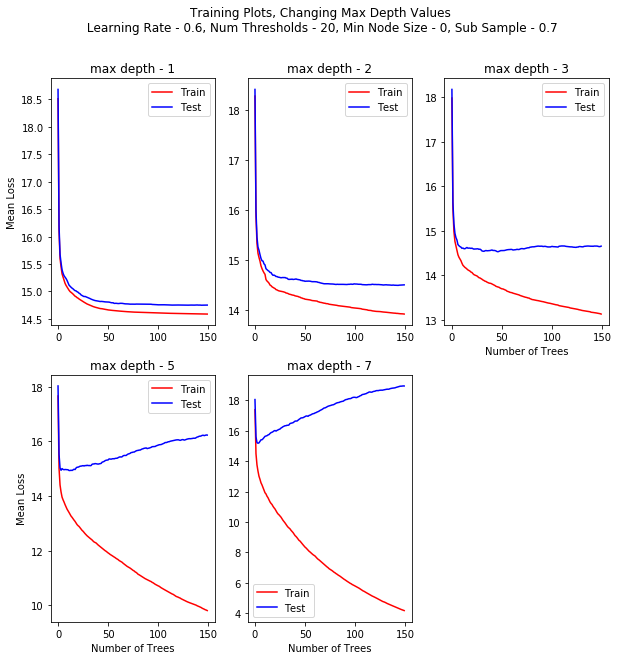

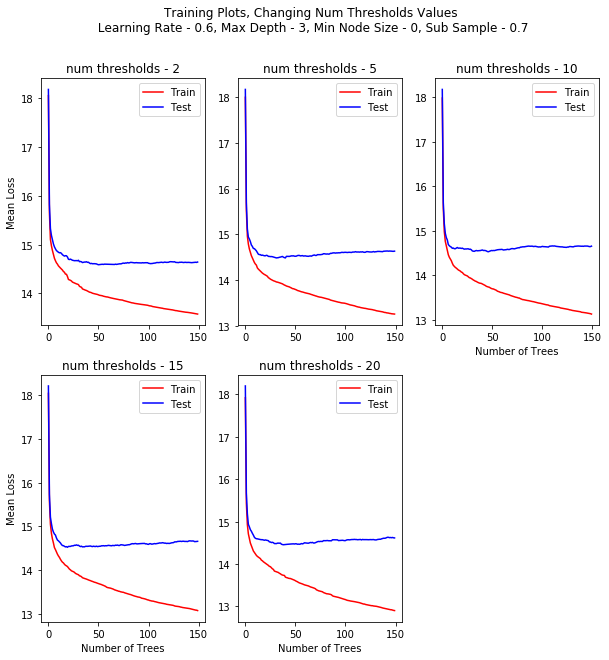

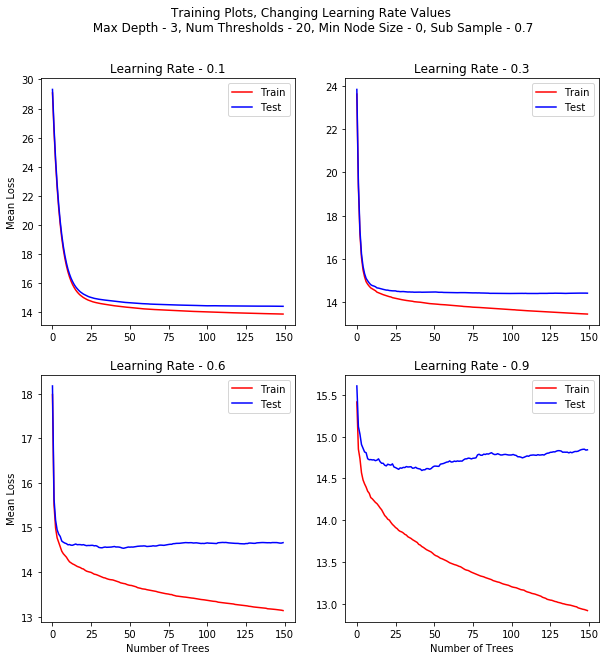

In [51]:
# Changing Max Depth
plt.figure(figsize=(10,10))
plt.suptitle('Training Plots, Changing Max Depth Values\n Learning Rate - 0.6, Num Thresholds - 20, Min Node Size - 0, Sub Sample - 0.7')
max_depth_tups=[(1, 0.6, 10), (2, 0.6, 10), (3, 0.6, 10), (5, 0.6, 10), (7, 0.6, 10)]
for ind, tup in enumerate(max_depth_tups):
    plt.subplot(2, 3, ind+1)
    
    plt.title('max depth - {}'.format(tup[0]))

    tr = models_data[tup]['train_loss']
    te = models_data[tup]['test_loss']
    plt.plot(range(len(tr)), tr, c='red', label='Train')
    plt.plot(range(len(te)), te, c='blue', label='Test')

    plt.legend()

    if ind % 3 == 0:
        plt.ylabel('Mean Loss')
    if ind > 1:
        plt.xlabel('Number of Trees')  
          
plt.legend()
plt.show()

# Changing Num Thresholds
plt.figure(figsize=(10,10))
plt.suptitle('Training Plots, Changing Num Thresholds Values\n Learning Rate - 0.6, Max Depth - 3, Min Node Size - 0, Sub Sample - 0.7')
thresh_tups=[(3, 0.6, 2), (3, 0.6, 5), (3, 0.6, 10), (3, 0.6, 15), (3, 0.6, 20)]
for ind, tup in enumerate(thresh_tups):
    plt.subplot(2, 3, ind+1)
    
    plt.title('num thresholds - {}'.format(tup[2]))

    tr = models_data[tup]['train_loss']
    te = models_data[tup]['test_loss']
    plt.plot(range(len(tr)), tr, c='red', label='Train')
    plt.plot(range(len(te)), te, c='blue', label='Test')

    plt.legend()

    if ind % 3 == 0:
        plt.ylabel('Mean Loss')
    if ind > 1:
        plt.xlabel('Number of Trees')    

plt.legend()
plt.show()


# Changing Learning Rate
plt.figure(figsize=(10,10))
plt.suptitle('Training Plots, Changing Learning Rate Values\n Max Depth - 3, Num Thresholds - 20, Min Node Size - 0, Sub Sample - 0.7')
lr_tups=[(3, 0.1, 10), (3, 0.3, 10), (3, 0.6, 10), (3, 0.9, 10)]
for ind, tup in enumerate(lr_tups):
    plt.subplot(2, 2, ind+1)
    
    plt.title('Learning Rate - {}'.format(tup[1]))

    tr = models_data[tup]['train_loss']
    te = models_data[tup]['test_loss']
    plt.plot(range(len(tr)), tr, c='red', label='Train')
    plt.plot(range(len(te)), te, c='blue', label='Test')

    plt.legend()

    if ind % 2 == 0:
        plt.ylabel('Mean Loss')
    if ind > 1:
        plt.xlabel('Number of Trees')   

plt.legend()

plt.show()

** Plots Comparing the test losses for each Parameter **

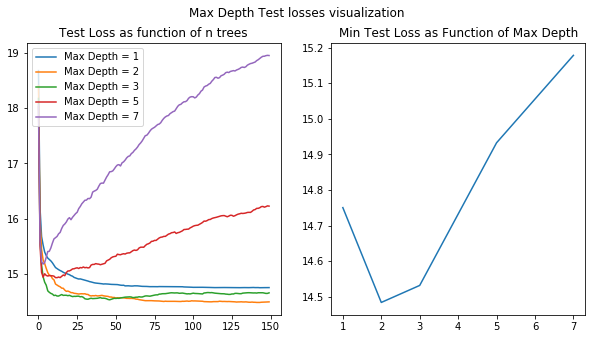

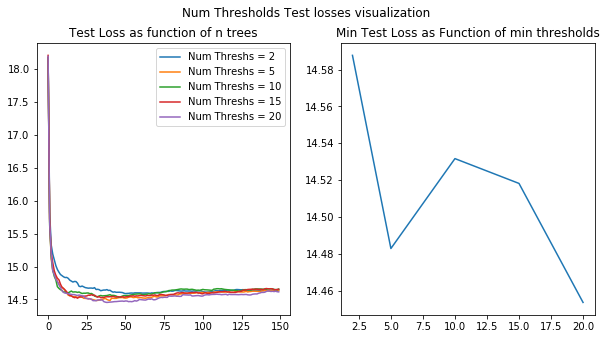

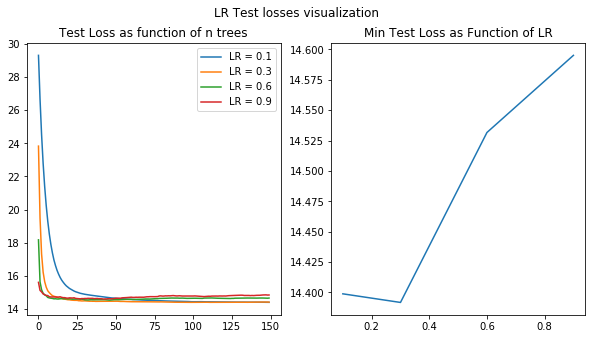

In [62]:
# Changing Max Depth
plt.figure(figsize=(10, 5))
plt.suptitle('Max Depth Test losses visualization')
for ind, tup in enumerate(max_depth_tups):
    plt.subplot(1,2,1)
    plt.title('Test Loss as function of n trees')
    tr = models_data[tup]['train_loss']
    te = models_data[tup]['test_loss']
    plt.plot(range(len(te)), te, label='Max Depth = {}'.format(tup[0]))
    plt.legend()
    
plt.subplot(1,2,2)
plt.title('Min Test Loss as Function of Max Depth')
mins_depth = [min(models_data[tup]['test_loss']) for tup in max_depth_tups]
depth_vals = [tup[0] for tup in max_depth_tups]
plt.plot(depth_vals, mins_depth)
    
plt.show()

# Changing Num Thresholds
plt.figure(figsize=(10, 5))
plt.suptitle('Num Thresholds Test losses visualization')
for ind, tup in enumerate(thresh_tups):
    plt.subplot(1,2,1)
    plt.title('Test Loss as function of n trees')
    tr = models_data[tup]['train_loss']
    te = models_data[tup]['test_loss']
    plt.plot(range(len(te)), te, label='Num Threshs = {}'.format(tup[2]))
    plt.legend()
    
plt.subplot(1,2,2)
plt.title('Min Test Loss as Function of min thresholds')
mins_threshs = [min(models_data[tup]['test_loss']) for tup in thresh_tups]
threshs_vals = [tup[2] for tup in thresh_tups]
plt.plot(threshs_vals, mins_threshs)
    
plt.show()

# Changing Learning Rate
plt.figure(figsize=(10, 5))
plt.suptitle('LR Test losses visualization')
for ind, tup in enumerate(lr_tups):
    plt.subplot(1,2,1)
    plt.title('Test Loss as function of n trees')
    tr = models_data[tup]['train_loss']
    te = models_data[tup]['test_loss']
    plt.plot(range(len(te)), te, label='LR = {}'.format(tup[1]))
    plt.legend()
    
plt.subplot(1,2,2)
plt.title('Min Test Loss as Function of LR')
mins_threshs = [min(models_data[tup]['test_loss']) for tup in lr_tups]
threshs_vals = [tup[1] for tup in lr_tups]
plt.plot(threshs_vals, mins_threshs)
    
plt.show()



# Deliverable 3 - Training time plots

Hyperparams impact on runtime analysis. Here we Plot the time it takes to train a
boosted tree ensemble with 300 trees as function of hyperparameters. 
We chose to show plots varying the Max Depth and The Num Thresholds.


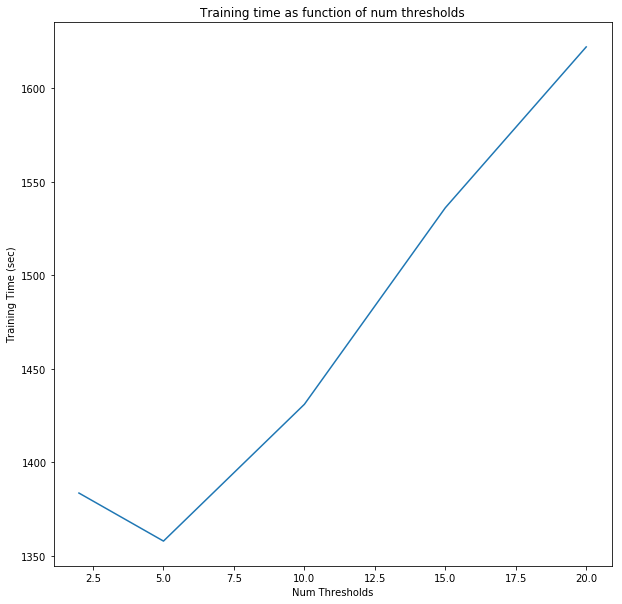

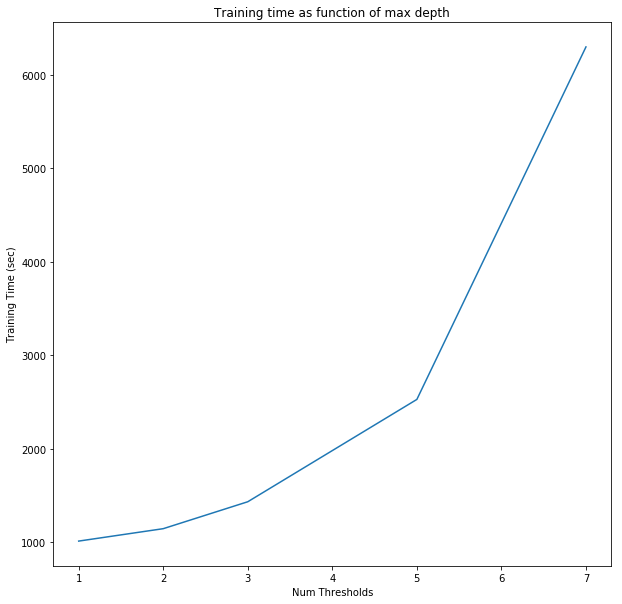

In [18]:
num_threshs = [2, 5, 10, 15, 20]
depths = [1, 2, 3, 5, 7]

tups1=[(3, 0.6, n) for n in num_threshs]
tups2=[(n, 0.6, 10) for n in depths]

times1 = [models_data[tup]['training_time'] for tup in tups1]
times2 = [models_data[tup]['training_time'] for tup in tups2]


plt.figure(figsize=(10,10))
plt.title('Training time as function of num thresholds')    
plt.plot(num_threshs, times1)
plt.xlabel('Num Thresholds')
plt.ylabel('Training Time (sec)')    
plt.show()

plt.figure(figsize=(10,10))
plt.title('Training time as function of max depth')    
plt.plot(depths, times2)
plt.xlabel('Num Thresholds')
plt.ylabel('Training Time (sec)')    
plt.show()

# Deliverable 4 - Feature Importance

For a particular learned model we will show some tree splits and analyze the feature importance.

#### We print here the first 5 trees of the tree ensemble in a readable ”if-then” format: 

In [20]:
for idx, tree in enumerate(best_model.trees):
    print('Tree #%d partition description' % (idx))
    print('==============================')
    tree.root.print_sub_tree()
    if idx == 4:
        break

Tree #0 partition description
if x['T1_V11'] <= 5.0 then:
	if x['T1_V12'] <= 3.0 then:
		if x['T1_V16'] <= 3.0 then:
			return -3.043510001460067
		if x['T1_V16'] > 3.0 then:
			return -3.785351231591294
	if x['T1_V12'] > 3.0 then:
		if x['T1_V8'] <= 3.0 then:
			return -5.766937669376694
		if x['T1_V8'] > 3.0 then:
			return -10.6875
if x['T1_V11'] > 5.0 then:
	if x['T1_V8'] <= 2.0 then:
		if x['T1_V4'] <= 4.0 then:
			return -3.8816130225675174
		if x['T1_V4'] > 4.0 then:
			return -4.853544776119403
	if x['T1_V8'] > 2.0 then:
		if x['T1_V8'] <= 3.0 then:
			return -4.982078853046595
		if x['T1_V8'] > 3.0 then:
			return -8.533477321814255
Tree #1 partition description
if x['T1_V2'] <= 14 then:
	if x['T1_V8'] <= 2.0 then:
		if x['T1_V12'] <= 3.0 then:
			return -1.1722512824522509
		if x['T1_V12'] > 3.0 then:
			return -2.843530530765222
	if x['T1_V8'] > 2.0 then:
		if x['T1_V7'] <= 3.0 then:
			return -2.416791866524516
		if x['T1_V7'] > 3.0 then:
			return -25.551575305528733
if x[

#### Creates and sort the features importance

In [21]:
features_dict = ensemble_feature_importance(test_dataset.data, train_dataset.label_name, best_model)
n = 10
features_dict = sorted(features_dict.items(), key=operator.itemgetter(1), reverse=True)[0:n]

features_dict = pd.DataFrame(features_dict, columns=['feature', 'score'])
features_dict

,feature,score
0,T1_V8,1.000000
1,T1_V2,0.397338
2,T1_V11,0.339258
3,T1_V12,0.274907
4,T1_V16,0.259862
5,T1_V4,0.259335
6,T1_V1,0.245364
7,T1_V5,0.197065
8,T2_V15,0.196557
9,T1_V15,0.141970


#### Bar Plot of feature importance for the 10 most important features:

Text(0,0.5,'score')

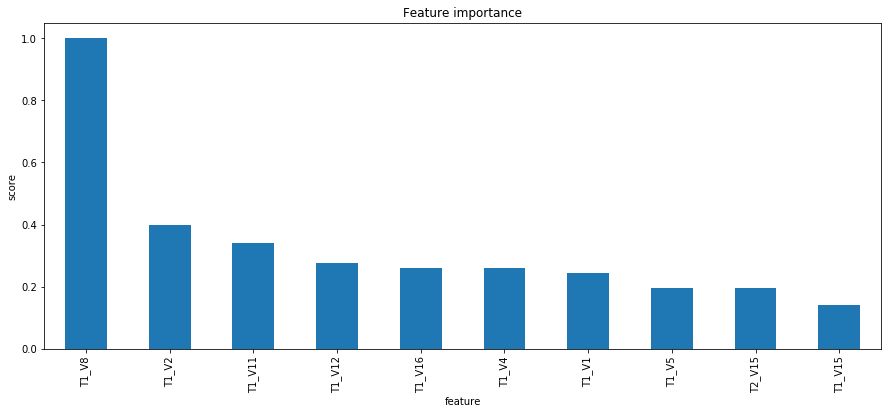

In [22]:
plot = features_dict.plot(kind='bar',legend=None,title="Feature importance", x='feature', figsize=(15,6))
plot.set_xlabel("feature")
plot.set_ylabel("score")

# Deliverable 5 - Scores On Kaggle

**To train out final model, we chose the parameters that reached the minimum loss on the test set over all combinations**
<br> We then train a model on all the data (train and test) using those parameters. This model will be used to predict the samples on the test set from the kaggle competition.


In [111]:
# Find best params

best_test_loss = np.inf
best_params = None

for k in models_data:
    model_log = models_data[k]
    model_min_test_loss = min(model_log['test_loss'])
    if model_min_test_loss < best_test_loss:
        best_test_loss = model_min_test_loss
        best_params = model_log['params']
        best_params.num_trees = np.argmin(model_log['test_loss']) + 1

In [79]:
# train model on all data

train_dataset_all, test_dataset_all = parse_data(TRAIN_DATA_PATH, label_name=LABEL_NAME, train_percent=0.99)  
best__params = HParams(num_trees=98, max_depth=3, min_node_size=0, weight_decay=0.3, sub_samp=0.7, num_thresholds=10, verbose=1)
best_model_all_data, _ = gbrt(train_data=train_dataset_all.data, test_data=test_dataset_all.data, 
                   label_name=train_dataset_all.label_name, params=best__params)

Add tree number 1
Train mean loss is: 23.693642573042982
Test mean loss is: 23.949314179417204
Add tree number 2
Train mean loss is: 19.39253374452931
Test mean loss is: 19.1343911837711
Add tree number 3
Train mean loss is: 17.267786305455875
Test mean loss is: 16.95218376805485
Add tree number 4
Train mean loss is: 16.132458834215853
Test mean loss is: 15.568728941306
Add tree number 5
Train mean loss is: 15.516900134716547
Test mean loss is: 14.960377254747534
Add tree number 6
Train mean loss is: 15.175198480509561
Test mean loss is: 14.572937501785724
Add tree number 7
Train mean loss is: 14.982440496544758
Test mean loss is: 14.381669997188801
Add tree number 8
Train mean loss is: 14.85735483397384
Test mean loss is: 14.225856493572627
Add tree number 9
Train mean loss is: 14.74086747449393
Test mean loss is: 14.082094888674861
Add tree number 10
Train mean loss is: 14.67051826285671
Test mean loss is: 14.074330276141689
Add tree number 11
Train mean loss is: 14.602141954321192
T

Add tree number 87
Train mean loss is: 13.831287576456209
Test mean loss is: 13.723058383839376
Add tree number 88
Train mean loss is: 13.827855281982476
Test mean loss is: 13.7361166699369
Add tree number 89
Train mean loss is: 13.82555018681415
Test mean loss is: 13.739815852330949
Add tree number 90
Train mean loss is: 13.822985783075733
Test mean loss is: 13.738140741162342
Add tree number 91
Train mean loss is: 13.818704906389776
Test mean loss is: 13.742569600941787
Add tree number 92
Train mean loss is: 13.814075461156653
Test mean loss is: 13.7427261728519
Add tree number 93
Train mean loss is: 13.809847949075838
Test mean loss is: 13.744176466057624
Add tree number 94
Train mean loss is: 13.804968149333023
Test mean loss is: 13.738615354395575
Add tree number 95
Train mean loss is: 13.80239016136646
Test mean loss is: 13.743300197690434
Add tree number 96
Train mean loss is: 13.800514232899195
Test mean loss is: 13.728334896253523
Add tree number 97
Train mean loss is: 13.7964

## Scores On Kaggle Leaderboard:

### Liberty Mutual Group Property Inspection Prediction

In [110]:
kaggle_test_dataset = parse_data('./data_liberty/test.csv', label_name=LABEL_NAME, for_train=False, 
           train_dataset=train_dataset)
pred = kaggle_test_dataset.data.apply(lambda x: best_model_all_data.evaluate(x, 97), axis=1)
pd.DataFrame({'Id': pred.index, 'Hazard': pred.values}).to_csv('./pred2.csv')

#### Score 0.363357 - place 1523 out of 2236

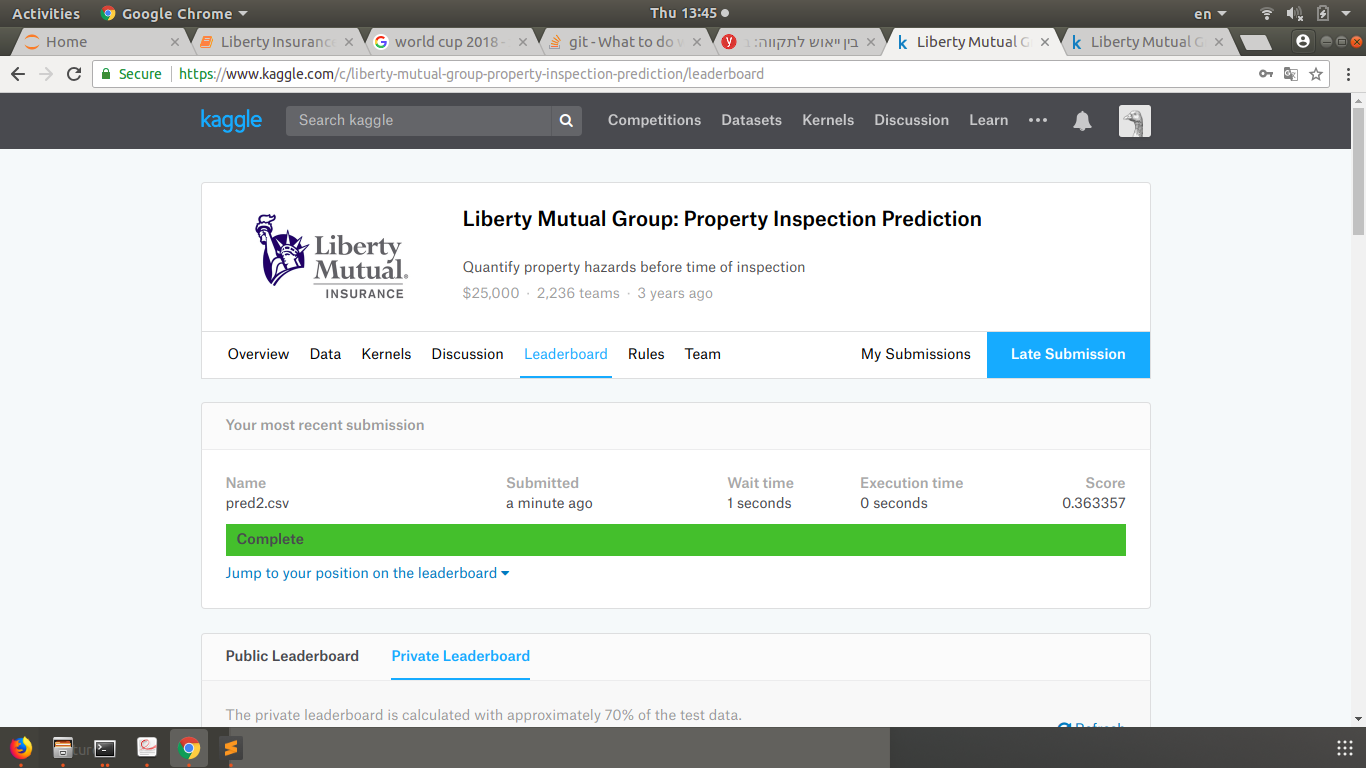

In [108]:
from IPython.display import Image
Image(filename='kaggle_score.png') 

### Housing Data